หลังจากที่ใน ep ก่อน เราได้ใช้ LR_Find Callback หา Learning Rate ที่ดีที่สุดได้แล้ว แล้วเราจะนำมาใช้อย่างไร Learning Rate ถือว่าเป็นหนึ่งใน Hyperparameter ที่สำคัญที่สุดในการเทรน Machine Learning 

มีแนวคิดจากหลากหลาย Paper ที่ว่า ในแต่ละ State ของการเทรน Deep Neural Network นั้นต้องการ Hyperparameter ต่างกันไป เช่น ตอนเริ่มเทรน เรายังไม่รู้ว่า Global Minima อยู่ไหน โมเดลจะไปทางไหนดี ไม่ควรรีบร้อนใช้ Learning Rate สูง จะทำให้กระโดดไปผิดทางได้, ช่วงท้ายของการเทรน เราก็ควรลด Learning Rate ลงเพื่อ Fine Tune ไม่ให้โมเดลกระโดดออกมาจากหลุม Global Minima, etc.

ดังนั้นเราควรจะ Schedule ทุก Hyperparamter ใน ep นี้เราเริ่มต้นด้วยการ มาดูตัวอย่างการ Schedule Learning Rate ด้วย Callback กัน เริ่มต้นที่[หัวข้อ 6.1 ParamScheduler](#6.1-ParamScheduler)

# 0. Magic

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import

In [0]:
import torch
from torch import tensor
from torch.nn import *
import torch.nn.functional as F
from torch.utils.data import *
from fastai import datasets
from fastai.metrics import accuracy
from fastai.basic_data import *
from fastai.basic_train import *
import pickle, gzip, math, torch, re
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from functools import partial

# 2. Data

In [0]:
class Dataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [0]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [0]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train, y_train, x_valid, y_valid))

In [0]:
x_train, y_train, x_valid, y_valid = get_data()

# 3. Data Preprocessing

In [0]:
def normalize(x, m, s): 
    return (x-m)/s

In [0]:
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [0]:
_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')

def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()   

In [0]:
train_mean, train_std = x_train.mean(), x_train.std()
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [0]:
nh, bs = 100, 256
n, m = x_train.shape
c = (y_train.max()+1).numpy()
loss_func = F.cross_entropy

In [0]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
train_dl, valid_dl = DataLoader(train_ds, bs), DataLoader(valid_ds, bs)

In [0]:
data = DataBunch(train_dl, valid_dl)

# 4. Model

In [0]:
lr = 0.001
epoch = 10
nh = 32

In [0]:
def get_model():
    # loss function
    loss_func = F.cross_entropy
    model = Sequential(Linear(m, nh), ReLU(), Linear(nh,c))
    return model, loss_func

# 5. Training Loop

Training Loop ที่รองรับ Callback

In [0]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop, self.cbs = False, [TrainEvalCallback()]+cbs

    @property
    def opt_func(self):     return self.learn.opt_func
    @property
    def model(self):        return self.learn.model
    @property
    def loss_func(self):    return self.learn.loss_func
    @property
    def data(self):         return self.learn.data

    def one_batch(self, xb, yb):
        try: 
            self.xb, self.yb = xb, yb
            self('begin_batch')
            self.pred = self.model(xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt_func.step()
            self('after_step')
            self.opt_func.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')
    
    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb, yb in dl:
                self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')
    
    def fit(self, epochs, learn):
        self.epochs, self.learn, self.loss = epochs, learn, tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
        except CancelTrainException: self('after_cancel_train')
        finally: 
            self('after_fit')
            self.train = None

    def __call__(self, cb_name):
        # return True = Cancel, return False = Continue (Default)
        res = False
        # check if at least one True return True
        for cb in sorted(self.cbs, key=lambda x: x._order): res = res or cb(cb_name)
        return res        

# 6. Callbacks

In [0]:
class Callback():
    _order = 0
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)

    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0.
        self.run.n_iter = 0
    
    def begin_epoch(self):
        self.run.n_epochs = self.epoch  
        self.model.train()
        self.run.in_train=True

    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter += 1

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False    
           
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [0]:
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics, True), AvgStats(metrics, False)
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
    
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)

    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

class AvgStats():
    def __init__(self, metrics, in_train): 
        self.metrics, self.in_train = listify(metrics), in_train
    
    def reset(self):
        self.tot_loss, self.count = 0., 0
        self.tot_mets = [0.] * len(self.metrics)

    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        
        for i, m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class Recorder(Callback):
    def begin_fit(self): 
        self.lrs = [[] for _ in self.opt_func.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg, lr in zip(self.opt_func.param_groups, self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())
    
    def plot_lr(self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

## 6.1 ParamScheduler

เราจะสร้าง Callback ที่จะ Schedule Hyperparameter โดยรับชื่อ Hyperparameter และ Schdule Function จากภายนอก


In [0]:
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_funcs): self.pname, self.sched_funcs = pname, sched_funcs

    def begin_fit(self): 
        if not isinstance(self.sched_funcs, (list, tuple)): 
            self.sched_funcs = [self.sched_funcs] * len(self.opt_func.param_groups)

    def set_param(self):
        assert len(self.opt_func.param_groups) == len(self.sched_funcs)
        for pg, f in zip(self.opt_func.param_groups, self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)

    def begin_batch(self):
        if self.in_train: self.set_param()

เราจะใช้ Decorator มาอำนวยความสะดวก ในการสร้าง Partial Function ของ Schedule Function ใด ๆ ที่รับ start, end, pos ให้เหลือเป็น pos ตัวเดียว พร้อมใช้ส่งให้กับ ParamScheduler.set_param ที่จะเรียก f(self.n_epochs/self.epochs)

In [0]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner 

ประกาศ Linear Schedule Function ฟังก์ชันกำหนดการแบบเส้นตรง

In [0]:
@annealer
def sched_lin(start, end, pos): return start + pos * (end - start)

ลองเทส sched_lin ช่วงระหว่าง 0 ถึง 5 เทสเรียกด้วย State ต่าง ๆ ของการเทรน

In [22]:
f = sched_lin(0, 5)
f(0.1), f(0.3), f(0.6), f(0.9)

(0.5, 1.5, 3.0, 4.5)

ประกาศ Schedule Function แบบต่าง ๆ เช่น Cosine, No Schedule, Exponential

In [0]:
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2

@annealer
def sched_no(start, end, pos): return start

@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

กำหนด Property Tensor.ndim เพื่อใช้ในการพล็อตกราฟด้วย Matplotlib

In [0]:
torch.Tensor.ndim = property(lambda x: len(x.shape))

ลองพล็อตกราฟ ฟังก์ชัน Schedule ทั้ง 4 แบบ

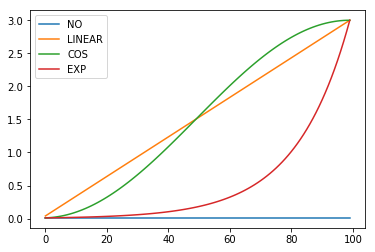

In [25]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01, 1, 100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(1e-2, 3)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

ในการใช้งานจริงของ Schedule เรามักจะรวม Schedule แบบต่าง ๆ ในช่วงต่าง ๆ เข้าด้วยกัน เพื่อให้ได้ Curve ที่เราต้องการ

In [0]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)

    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner    

เราจะรวม Cosine Schedule Function 2 ช่วงเข้าด้วยกัน ด้วยสัดส่วน 30/70 ให้ได้กราฟของ Learning Rate เริ่มที่ 0.03 แล้วค่อย ๆ เพิ่มขึ้นจนถึงค่า Max = 0.1 แล้วค่อย ๆ ลดลงมาที่ 0.02 แบบ Smooth 

In [0]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.03, 0.1), sched_cos(0.1, 0.02)])

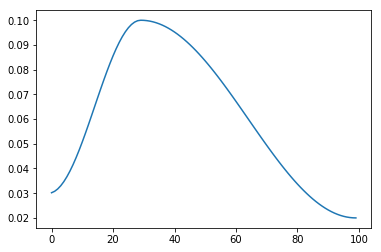

In [28]:
plt.plot(a, [sched(o) for o in p])

เราจะใช้ 2 Callback ในการเทรนครั้งนี้ คือ Record Callback ไว้บันทึก Learning Rate, Loss และ ParamScheduler Callback ไว้ Schedule lr (Learning Rate) ดังกราฟด้านบน

In [0]:
cbfs = [Recorder, partial(ParamScheduler, 'lr', sched)]

# 7. Train

เริ่มต้นเทรน ด้วย SGD ไปแค่ 1 Epoch ก็พอ

In [30]:
model, loss_func = get_model()
opt = torch.optim.SGD(model.parameters(), lr=lr)
learn = Learner(data, model, opt, loss_func=loss_func)

run = Runner(cb_funcs=cbfs, cbs=AvgStatsCallback([accuracy]))
run.fit(5, learn)

train: [0.724913515625, tensor(0.8178)]
valid: [0.348841796875, tensor(0.8994)]
train: [0.306468046875, tensor(0.9107)]
valid: [0.265300830078125, tensor(0.9217)]
train: [0.23935859375, tensor(0.9311)]
valid: [0.2135351318359375, tensor(0.9389)]
train: [0.20461296875, tensor(0.9420)]
valid: [0.18989019775390625, tensor(0.9450)]
train: [0.18814546875, tensor(0.9462)]
valid: [0.18178546142578125, tensor(0.9478)]


เทรนเสร็จเรียบร้อย ได้ Accuracy ประมาณ 95%

# 8. Interpret

เราลองพล็อตกราฟ Learning Rate

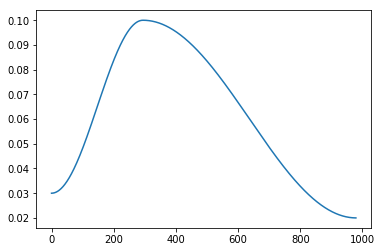

In [31]:
run.recorder.plot_lr()

พล็อตกราฟ Loss

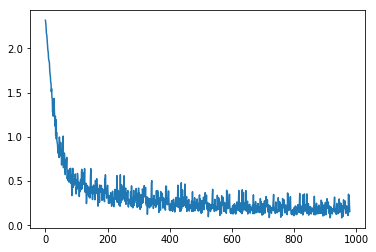

In [32]:
run.recorder.plot_loss()

# Credit

* https://course.fast.ai/videos/?lesson=9
* https://arxiv.org/pdf/1803.09820.pdf
* http://yann.lecun.com/exdb/mnist/